In [1]:
import numpy as np
import pylab as plt
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from matplotlib.ticker import FixedLocator
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import matplotlib.gridspec as gridspec
from pprint import pprint
from tqdm import tqdm
import math
from IPython.display import clear_output
plt.ion()
plt.show()

Implementation for algorithm described in : http://www.naun.org/main/NAUN/computers/20-713.pdf

In [2]:
P = 'HPHPPHHPHPPHPHHPPHPH'
print(len(P))
# TO DO create random generator for input population
P = list(P) # transform input string into array
print('input: ', P)

# this dictionary maps directions to integer values which can become indexes in actions matrix
moves = {'R':0, 'D': 1, 'L': 2, 'U': 3}
pi = 'RUULDLULLDRDRDLDRRU'
pi = list(pi)
pi = list(map(lambda x : moves[x], pi))
print(len(pi))
print('output: ', pi)

20
input:  ['H', 'P', 'H', 'P', 'P', 'H', 'H', 'P', 'H', 'P', 'P', 'H', 'P', 'H', 'H', 'P', 'P', 'H', 'P', 'H']
19
output:  [0, 3, 3, 2, 1, 2, 3, 2, 2, 1, 0, 1, 0, 1, 2, 1, 0, 0, 3]


Utility methods for visualisation of policies:

[(2, 3), (2, 4), (3, 4), (4, 4), (4, 3), (3, 3), (3, 2), (4, 2), (4, 1), (4, 0), (3, 0), (3, 1), (2, 1), (2, 2), (1, 2), (1, 1), (0, 1), (0, 2), (0, 3), (1, 3)] [[ 0. -1.  1. -1.  0.]
 [ 0. -1.  1.  1.  0.]
 [ 0. -1.  1.  1. -1.]
 [-1.  1.  1.  1.  1.]
 [-1.  1. -1. -1. -1.]]


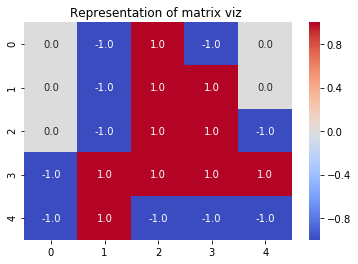

In [3]:
def updateCurrentIndex(x, y, action):
    if action == moves['U']:
        x = x + 1
    elif action == moves['D']:
        x = x - 1
    elif action == moves['R']:
        y = y + 1
    else:
        y = y - 1
    return x, y

def getActionValue(prot_type):
    return 1 if prot_type == 'H' else -1

"""
Visualize the content of a matrix as a heatmap
"""
def plotMatrix(m, label = ''):
    plt.title('Representation of matrix %s '%(label))
    sns.heatmap(m,  cmap='coolwarm', annot=True, fmt=".1f");

"""
Generates a matrix representing the 2D model of the protein based on the sequence of actions pi
"""
def getVisualizationMatrixAndPoints(P, pi):
    l = 2* len(pi)
    viz = np.zeros([l+1, l+1]) # visualization matrix initialized with 0
    points = [] # this will hold the order of points
    cur_x, cur_y = len(pi), len(pi)
    points.append((cur_x, cur_y))
    viz [cur_x, cur_y] = getActionValue(P[0]) # initialize center of the matrix
    for  action, prot_type in zip(pi, P[1:]):   
        cur_x, cur_y = updateCurrentIndex(cur_x, cur_y, action)
        viz [cur_x, cur_y] = getActionValue(prot_type)
        points.append((cur_x, cur_y))
        
    points = list(map(list, zip(*points))) # separate list of tuple points into a list with 2 arrays: x an y coordinates
    # substract from x and y coordinates min values in order to remove 0 based columns and rows
    points = list(zip(list(map(lambda x: x - min(points[0]), points[0] )),
        list(map(lambda x: x - min(points[1]), points[1] ))))
    
    # this removes all columns and rows padded with 0s
    viz = viz[~np.all(viz == 0, axis=1)]
    viz = viz[:, ~np.all(viz == 0, axis=0)]
        
    return viz, points


viz, points =getVisualizationMatrixAndPoints(P, pi)
print(points, viz)

plotMatrix(viz, 'viz')

In [4]:
"""
This method generates an annotated graph representation for the input string of hydrophobic / polar aminacids 
and the policy pi of actions to be taken at each step
"""

def plotSolution(P, pi):
    viz, lines = getVisualizationMatrixAndPoints(P, pi)
    print(viz, lines)
    
    fig = plt.figure(figsize=(7,7))
    # set circleSize and plot
    circleSize = 1000 # in points²
    
    # Split graphic into 2 sections for the 2d map and the input viz
    gs = gridspec.GridSpec(2, 1, width_ratios=[1], height_ratios=[5,1]) 
    
    # Section1 : 2D map
    ax = plt.subplot(gs[0]) # use first grid spec

    y, x = np.where(viz == 1) # hydrophobic AA
    plt.scatter(x, y, s=circleSize, c='orange', alpha=0.4)

    y, x = np.where(viz == -1) # hydrophilic AA
    plt.scatter(x, y, s=circleSize, c='green', alpha=0.4 )
    
    plt.legend(['Hydrophobic amino acids', 'Hydrophilic amino acids '], loc='center left', bbox_to_anchor=(1, 0.5),
               fancybox=True, shadow=True)
#     plt.xlim(0,5)
#     plt.ylim(0,5)

    figSize = (fig.get_figwidth(),fig.get_figheight()) # in inches
    axSize = (plt.xlim()[1]-plt.xlim()[0],plt.ylim()[1]-plt.ylim()[0]) # in 'axis units'
    circleRadius = math.sqrt(circleSize/math.pi) # in points (dots)
    circleRadius /= fig.dpi # in inches
    circleHOffset = circleRadius * (axSize[0]/figSize[0]) # inch * (axis/inch) -> axis
    circleVOffset = circleRadius * (axSize[1]/figSize[1]) # inch * (axis/inch) -> axis

    shrinkHV = [circleHOffset, circleVOffset]
    
    # Write numbers on circles
    for i, point in enumerate(lines):
        if i + 1 == len(lines):
            ax.annotate(i + 1, xy=(point[1], point[0]), va="center", ha="center")
            break
        nextPoint = lines[i+1]
        ax.annotate(i + 1, 
                    xy=(point[1] , point[0]),
                    va="center", ha="center",
                   )
        ax.annotate('', 
                    xytext=(point[1] , point[0] ),
                    xy=(nextPoint[1] , nextPoint[0]),
                    arrowprops=dict(facecolor='black', shrink=shrinkHV[int(nextPoint[0]!=point[0])]),
                       )


    plt.xticks([], [])
    plt.yticks([], [])
    grid_indexes = np.arange(viz.shape[0])
    grid_indexes = grid_indexes + 0.5
    minor_locator = FixedLocator(grid_indexes)
    ax.xaxis.set_minor_locator(minor_locator)


    grid_indexes = np.arange(viz.shape[1])
    grid_indexes = grid_indexes + 0.5
    minor_locator = FixedLocator(grid_indexes)
    ax.yaxis.set_minor_locator(minor_locator)




    plt.grid(which='minor')
    sns.despine()
    plt.title('2D representation of proteins')

    # Section2 : input/ policy annotation
    ax = plt.subplot(gs[1])

    at = AnchoredText("Input: \n %s \n Directions: \n %s" % (P, pi),
                      prop=dict(size=12), frameon=True,
                      loc=1,
                      )
    at.patch.set_boxstyle("round,pad=0.2,rounding_size=0.4")
    ax.add_artist(at)

    plt.axis('off');
#     plt.tight_layout()
    
# plotSolution(P, pi)

[[ 0. -1.  1. -1.  0.]
 [ 0. -1.  1.  1.  0.]
 [ 0. -1.  1.  1. -1.]
 [-1.  1.  1.  1.  1.]
 [-1.  1. -1. -1. -1.]] [(2, 3), (2, 4), (3, 4), (4, 4), (4, 3), (3, 3), (3, 2), (4, 2), (4, 1), (4, 0), (3, 0), (3, 1), (2, 1), (2, 2), (1, 2), (1, 1), (0, 1), (0, 2), (0, 3), (1, 3)]


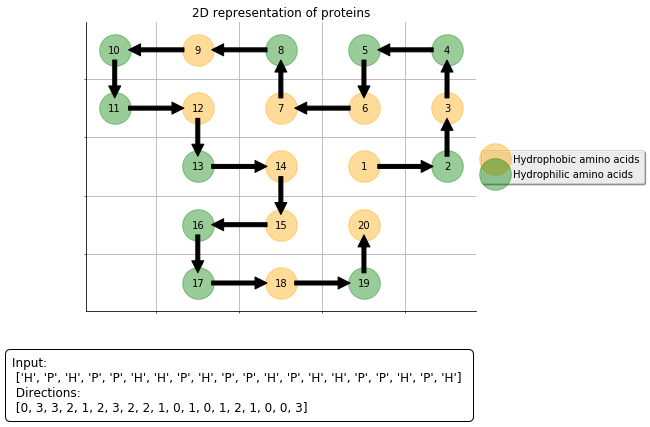

In [5]:
plotSolution(P, pi)

The following method validates a configuration :
<img src ='img/valid_configuration.PNG'> </img>

In [6]:
def validConfiguration(points):
    for i, point in enumerate(points):
        if i+1 == len(points):
            return True
        
        if abs(points[i][0] - points[i + 1][0]) + abs(points[i][1] - points[i + 1][1]) != 1:
#             print('#', end = '')
            return False
        
        if len(points) != len(set(points)):
#             print('>', end = '')
            return False
        
validConfiguration(points)

True

<img src = 'img/energy_function.PNG'></img>

In [7]:
def energyFunction(points, P):
    I = 0
    for i in range(len(points)):
        for j in range(len(points)):
            if abs(i-j) >=2:
                if abs(points[i][0] - points[j][0]) + abs(points[i][1] - points[j][1]) == 1 and P[i] == 'H' and P[j] == 'H':
                    I = I -1
    return I // 2 # we have to divide by 2 because we considered the pairs twice
                    
                
energyFunction(points, P)              

-9

In [104]:
def reward(P, pi, log = False):
    viz, points =getVisualizationMatrixAndPoints(P, pi)

    if validConfiguration(points) == False:
        return 0.01
    
    if len(pi) == (len(P) -1):
        if log:
            print('VALID %s ' % pi)
        return -1 * energyFunction(points, P)
    return 0.1

def qScore(Q):
    if (np.max(Q) > 0):
        return(np.sum(Q/np.max(Q)*100))
    else:
        return (0)
    
reward(P, pi)

1

Static parameters:

In [9]:
N = len(P)-1 # number of iterations to cover the protein
gamma = .8 # discount factor for future rewards
lr= 0.8 # learning rare
MOVE_SIZE = 4 # number of available moves

## Implementation 1: Q has len(pi) states

In [10]:
Q = np.matrix(np.zeros([len(P),MOVE_SIZE]))
current_state = 0
actions = []
scores = [] 

for i in tqdm(range(1000)):
    actions = []
    for current_state in range(N):
        # Choose an action by as the best option from Q for current state + noise
        action= np.argmax(Q[current_state,:] + np.random.randn(1,MOVE_SIZE)*(1.0/(i+1))) # become less random over time
        actions.append(action)

        r = reward(P, actions)
        future_reward = np.max(Q[current_state + 1,:])
        Q[current_state, action] = (1-lr) * Q[current_state, action] + lr * ( r + gamma * future_reward)
    #     Q[current_state, action] = Q[current_state, action] + lr * ( r + gamma * future_reward)
        scores.append(qScore(Q))

        
plotSolution(P, actions)
plt.plot(scores)
plt.title('Q learning score evolution, final reward %s ' % (reward(P, actions)))
plt.show()
Q

  4%|██▋                                                                        | 3632/100000 [00:14<06:30, 246.50it/s]

KeyboardInterrupt: 

  4%|██▋                                                                        | 3632/100000 [00:30<13:16, 120.97it/s]

# Plot solution based on Q value

best step:  0 [1 2]
best step:  1 [1]
best step:  2 [1]
best step:  3 [1]
best step:  4 [0]
best step:  5 [1]
best step:  6 [0]
best step:  7 [0]
best step:  8 [3]
best step:  9 [3]
best step:  10 [0]
best step:  11 [3]
best step:  12 [2]
best step:  13 [3]
best step:  14 [2]
best step:  15 [1]
best step:  16 [1]
best step:  17 [1]
best step:  18 [0 1 2 3]
Most efficient path of length 19 has reward 0.01 is [1, 1, 1, 1, 0, 1, 0, 0, 3, 3, 0, 3, 2, 3, 2, 1, 1, 1, 1]
[[ 0.  1.  1.  1.  0.]
 [-1.  1. -1. -1.  0.]
 [-1.  0.  1. -1.  1.]
 [ 1.  0. -1.  1. -1.]
 [-1.  0. -1.  1.  0.]
 [ 1.  0.  0.  0.  0.]] [(5, 0), (4, 0), (3, 0), (2, 0), (1, 0), (1, 1), (0, 1), (0, 2), (0, 3), (1, 3), (2, 3), (2, 4), (3, 4), (3, 3), (4, 3), (4, 2), (3, 2), (2, 2), (1, 2), (0, 2)]


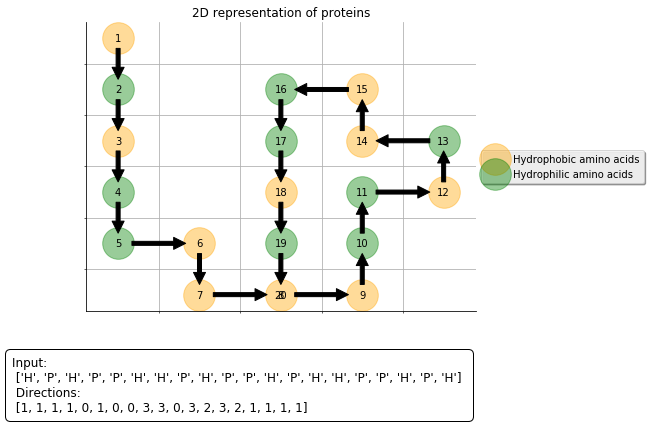

In [77]:
def verifySolutionQTable(P, Q):
    current_state = 0
    actions = []

    for i in range(N):

        next_step_index = np.where(Q[current_state,] == np.max(Q[current_state,]))[1]
        print('best step: ',str(i), next_step_index)
        if next_step_index.shape[0] > 1:
            next_step_index = int(np.random.choice(next_step_index, size = 1))
        else:
            next_step_index = int(next_step_index)

        actions.append(next_step_index)
        current_state = current_state + 1

    print("Most efficient path of length %s has reward %s is %s" % (len(actions), reward(P, actions), actions))

    plotSolution(P, actions)
    
verifySolutionQTable(P, Q)

## Implementation 2: Q has (4^n-1  - 1)/3

Use for initial POC a smaller chain HHPH  
Store Q as a dictionary with states as keys


4
input:  ['H', 'H', 'P', 'H']
3
output:  [2, 3, 0]
[[ 1.  1.]
 [-1.  1.]] [(0, 1), (0, 0), (1, 0), (1, 1)]
reward 1 


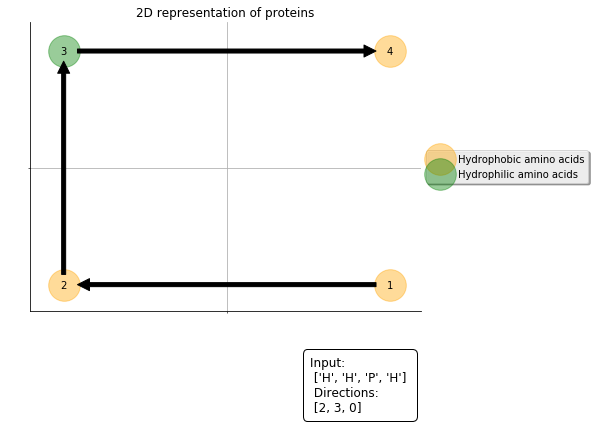

In [91]:
P = 'HHPH'
# P = 'HH'
print(len(P))
# TO DO create random generator for input population
P = list(P) # transform input string into array
print('input: ', P)

# this dictionary maps directions to integer values which can become indexes in actions matrix
moves = {'R':0, 'D': 1, 'L': 2, 'U': 3}
valueToMoves = {0 : 'R', 1: 'D', 2: 'L', 3 : 'U'}
pi = 'LUR'
pi = list(pi)
pi = list(map(lambda x : moves[x], pi))
print(len(pi))
print('output: ', pi)

plotSolution(P, pi)
print('reward %s ' % (reward(P, pi)))

In [73]:
def initializeQ(P):
    Q = {}
    directions = ['0', '1', '2', '3']
    states = None
    for el in range(len(P) - 1):
        if states == None:
            states = directions
            Q['start'] = [0] * MOVE_SIZE
            for e in directions:
                Q[str(e)] = [0] * MOVE_SIZE
        else:
            newstates = []
            for i, j in itertools.product(states, directions):
                newstates.append(str(i) + str(j))
                Q[str(i) + str(j)] = [0] * MOVE_SIZE
                states = newstates
    return Q

P = ['H', 'H', 'P', 'H']
print(len(initializeQ(P)))
Q =initializeQ(P)
Q['0'][2] = 7 # how to update dictionary
Q

85


{'0': [0, 0, 7, 0],
 '00': [0, 0, 0, 0],
 '000': [0, 0, 0, 0],
 '001': [0, 0, 0, 0],
 '002': [0, 0, 0, 0],
 '003': [0, 0, 0, 0],
 '01': [0, 0, 0, 0],
 '010': [0, 0, 0, 0],
 '011': [0, 0, 0, 0],
 '012': [0, 0, 0, 0],
 '013': [0, 0, 0, 0],
 '02': [0, 0, 0, 0],
 '020': [0, 0, 0, 0],
 '021': [0, 0, 0, 0],
 '022': [0, 0, 0, 0],
 '023': [0, 0, 0, 0],
 '03': [0, 0, 0, 0],
 '030': [0, 0, 0, 0],
 '031': [0, 0, 0, 0],
 '032': [0, 0, 0, 0],
 '033': [0, 0, 0, 0],
 '1': [0, 0, 0, 0],
 '10': [0, 0, 0, 0],
 '100': [0, 0, 0, 0],
 '101': [0, 0, 0, 0],
 '102': [0, 0, 0, 0],
 '103': [0, 0, 0, 0],
 '11': [0, 0, 0, 0],
 '110': [0, 0, 0, 0],
 '111': [0, 0, 0, 0],
 '112': [0, 0, 0, 0],
 '113': [0, 0, 0, 0],
 '12': [0, 0, 0, 0],
 '120': [0, 0, 0, 0],
 '121': [0, 0, 0, 0],
 '122': [0, 0, 0, 0],
 '123': [0, 0, 0, 0],
 '13': [0, 0, 0, 0],
 '130': [0, 0, 0, 0],
 '131': [0, 0, 0, 0],
 '132': [0, 0, 0, 0],
 '133': [0, 0, 0, 0],
 '2': [0, 0, 0, 0],
 '20': [0, 0, 0, 0],
 '200': [0, 0, 0, 0],
 '201': [0, 0, 0, 0],
 '2

In [79]:
def qScoreDictionary(Q):
    Q = list(Q.values())
    if (np.max(Q) > 0):
        return(np.sum(Q/np.max(Q)*100))
    else:
        return (0)
    

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1287.58it/s]


[[ 1.  1.]
 [-1.  1.]] [(0, 1), (1, 1), (1, 0), (0, 0)]


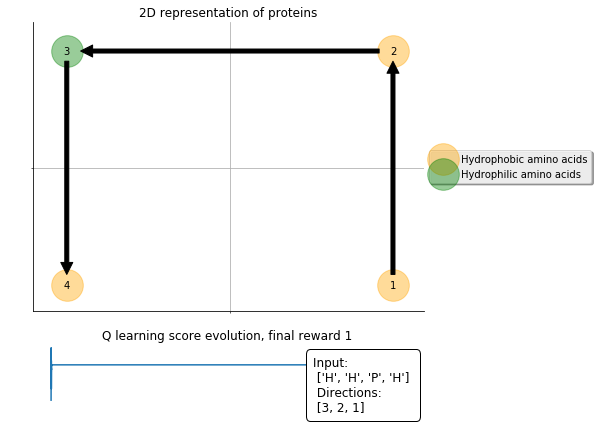

{'0': [0, 0, 0, 0],
 '00': [0, 0, 0, 0],
 '000': [0, 0, 0, 0],
 '001': [0, 0, 0, 0],
 '002': [0, 0, 0, 0],
 '003': [0, 0, 0, 0],
 '01': [0, 0, 0, 0],
 '010': [0, 0, 0, 0],
 '011': [0, 0, 0, 0],
 '012': [0, 0, 0, 0],
 '013': [0, 0, 0, 0],
 '02': [0, 0, 0, 0],
 '020': [0, 0, 0, 0],
 '021': [0, 0, 0, 0],
 '022': [0, 0, 0, 0],
 '023': [0, 0, 0, 0],
 '03': [0, 0, 0, 0],
 '030': [0, 0, 0, 0],
 '031': [0, 0, 0, 0],
 '032': [0, 0, 0, 0],
 '033': [0, 0, 0, 0],
 '1': [0, 0.080000000000000016, 0.096000000000000016, 0.0080000000000000002],
 '10': [0, 0, 0, 0],
 '100': [0, 0, 0, 0],
 '101': [0, 0, 0, 0],
 '102': [0, 0, 0, 0],
 '103': [0, 0, 0, 0],
 '11': [0, 0, 0.0, 0],
 '110': [0, 0, 0, 0],
 '111': [0, 0, 0, 0],
 '112': [0, 0, 0, 0],
 '113': [0, 0, 0, 0],
 '12': [0, 0.0, 0.0, 0],
 '120': [0, 0, 0, 0],
 '121': [0, 0, 0, 0],
 '122': [0, 0, 0, 0],
 '123': [0, 0, 0, 0],
 '13': [0, 0, 0, 0.0080000000000000002],
 '130': [0, 0, 0, 0],
 '131': [0, 0, 0, 0],
 '132': [0, 0, 0, 0],
 '133': [0, 0, 0, 0],
 '2'

In [111]:
Q= initializeQ(P)
gamma = .9 # discount factor for future rewards
lr= 0.8 # learning rare

current_state = 'start'
actions = []
scores = [] 

for i in tqdm(range(10000)):
    actions = []
    current_state = 'start'
    for _ in range(len(P) - 1):
        # Choose an action by as the best option from Q for current state + noise
        action= np.argmax(Q[current_state] + np.random.randn(1,MOVE_SIZE)*(1.0/(i+1))) # become less random over time

        actions.append(action)
        next_state = str(action) if current_state == 'start' else current_state + str(action)

        r = reward(P, actions)
        future_reward = np.max(Q[next_state])
        Q[current_state][int(action)] = (1-lr) * Q[current_state][int(action)] + lr * ( r + gamma * future_reward)
        current_state = next_state
        scores.append(qScoreDictionary(Q))

        
plotSolution(P, actions)
plt.plot(scores)
plt.title('Q learning score evolution, final reward %s ' % (reward(P, actions)))
plt.show()
Q

best action at step 0 is U, 3 
best action at step 1 is L, 2 
best action at step 2 is D, 1 
VALID [3, 2, 1] 
Most efficient path of length 3 has reward 1 is [3, 2, 1]
[[ 1.  1.]
 [-1.  1.]] [(0, 1), (1, 1), (1, 0), (0, 0)]


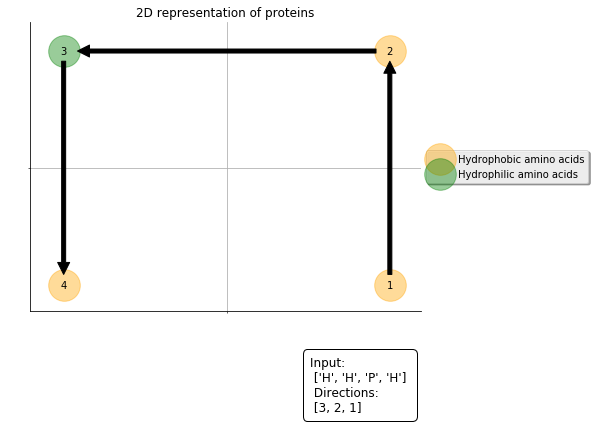

In [113]:
def verifySolutionQDictionary(P, Q):
    current_state = 'start'
    actions = []

    for i in range(len(P) - 1):

        next_step_index = np.where(Q[current_state] == np.max(Q[current_state]))[0]
        if next_step_index.shape[0] > 1:
            next_step_index = int(np.random.choice(next_step_index, size = 1))
        else:
            next_step_index = int(next_step_index)
        print('best action at step %s is %s, %s '% (str(i), valueToMoves[next_step_index], next_step_index))

        actions.append(next_step_index)
        current_state = str(action) if current_state == 'start' else current_state + str(next_step_index)

    print("Most efficient path of length %s has reward %s is %s" % (len(actions), reward(P, actions, True), actions))

    plotSolution(P, actions)
    
verifySolutionQDictionary(P, Q)

In [93]:
valueToMoves[0]

'R'

In [28]:
# from itertools import *
# import itertools


# for opt1 in [0,1,2,3]:
#     path = str(opt1)
#     print(path)
#     print('idx',4**(len(path)-1)+int(path, 4))
# for opt1, opt2 in itertools.product([0,1,2,3],[0,1,2,3]):
#     path = str(opt1)+str(opt2)
#     print(path)
#     print('idx',4**(len(path)-1)+int(path, 4))
# for opt1, opt2, opt3 in itertools.product([0,1,2,3],[0,1,2,3],[0,1,2,3]):
#     path = str(opt1)+str(opt2)+str(opt3)
#     print(path)
#     print('idx',4**(len(path)-1)+int(path, 4))
# for opt1, opt2, opt3, opt4 in itertools.product([0,1,2,3],[0,1,2,3],[0,1,2,3],[0,1,2,3]):
#     path = str(opt1)+str(opt2)+str(opt3)+str(opt4)
#     print(path)
#     print('idx',4**(len(path)-1)+int(path, 4))

0
idx 1
1
idx 2
2
idx 3
3
idx 4
00
idx 4
01
idx 5
02
idx 6
03
idx 7
10
idx 8
11
idx 9
12
idx 10
13
idx 11
20
idx 12
21
idx 13
22
idx 14
23
idx 15
30
idx 16
31
idx 17
32
idx 18
33
idx 19
000
idx 16
001
idx 17
002
idx 18
003
idx 19
010
idx 20
011
idx 21
012
idx 22
013
idx 23
020
idx 24
021
idx 25
022
idx 26
023
idx 27
030
idx 28
031
idx 29
032
idx 30
033
idx 31
100
idx 32
101
idx 33
102
idx 34
103
idx 35
110
idx 36
111
idx 37
112
idx 38
113
idx 39
120
idx 40
121
idx 41
122
idx 42
123
idx 43
130
idx 44
131
idx 45
132
idx 46
133
idx 47
200
idx 48
201
idx 49
202
idx 50
203
idx 51
210
idx 52
211
idx 53
212
idx 54
213
idx 55
220
idx 56
221
idx 57
222
idx 58
223
idx 59
230
idx 60
231
idx 61
232
idx 62
233
idx 63
300
idx 64
301
idx 65
302
idx 66
303
idx 67
310
idx 68
311
idx 69
312
idx 70
313
idx 71
320
idx 72
321
idx 73
322
idx 74
323
idx 75
330
idx 76
331
idx 77
332
idx 78
333
idx 79
0000
idx 64
0001
idx 65
0002
idx 66
0003
idx 67
0010
idx 68
0011
idx 69
0012
idx 70
0013
idx 71
0020
idx 72
00